In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, RocCurveDisplay
from sklearn.decomposition import PCA
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from keras.utils.vis_utils import plot_model

import warnings
warnings.filterwarnings("ignore")

In [5]:
df = pd.read_csv('/content/output.csv', index_col='Unnamed: 0')

## Preprocessing

Under normal circumstances, I would use a pipeline to clean up this code. However, using a pipeline in conjunction with evaluation or validation metrics for neural networks is difficult in regards to syntax. Thus, I'd rather preprocess outside of a pipeline.

In [6]:
# X / y definition
X = df.drop(columns=['label'])
y = df['label']

# Train Test Split
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=42,
    stratify=y
)

# SMOTE to address class imbalance (94/6)
sm = SMOTE()
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

# MinMaxScaler to address features with skewed distributions and different scales
mms = MinMaxScaler()
Xs_train = mms.fit_transform(X_train_sm)
Xs_test = mms.transform(X_test)

# PCA to address multi-collinearity
pca = PCA(
    n_components=8, 
    random_state=42)

# Adding a test case to show explained variance cutoff
pca_test = PCA(
    n_components=20,
    random_state=42
)

pca.fit(Xs_train)
pca_test.fit(Xs_train)

Z_train = pca.transform(Xs_train)
Z_test = pca.transform(Xs_test)

In [7]:
# After n_components=8, the variance that PCA explains doesn't increase much at all
np.cumsum(pca.explained_variance_ratio_)

array([0.89511954, 0.95196403, 0.9682259 , 0.98078314, 0.98759246,
       0.9909892 , 0.99344142, 0.99505996])

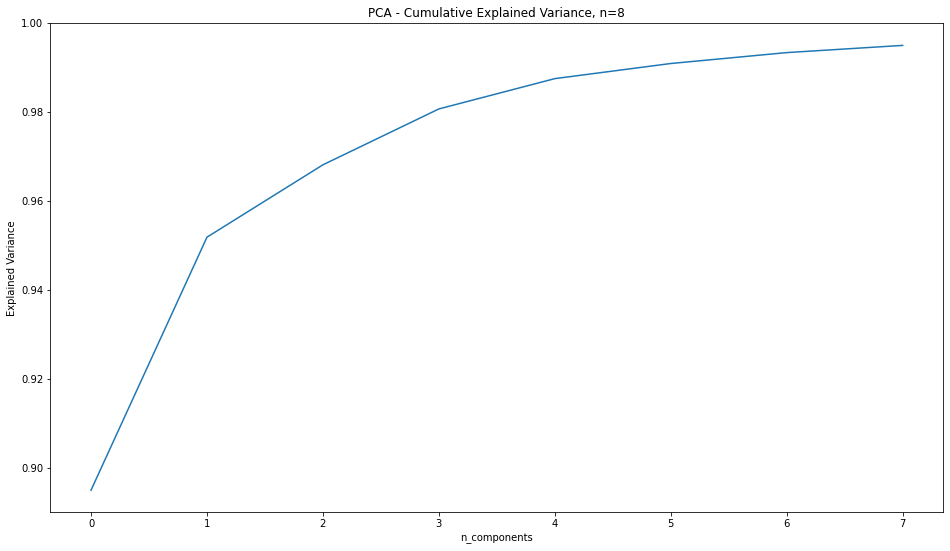

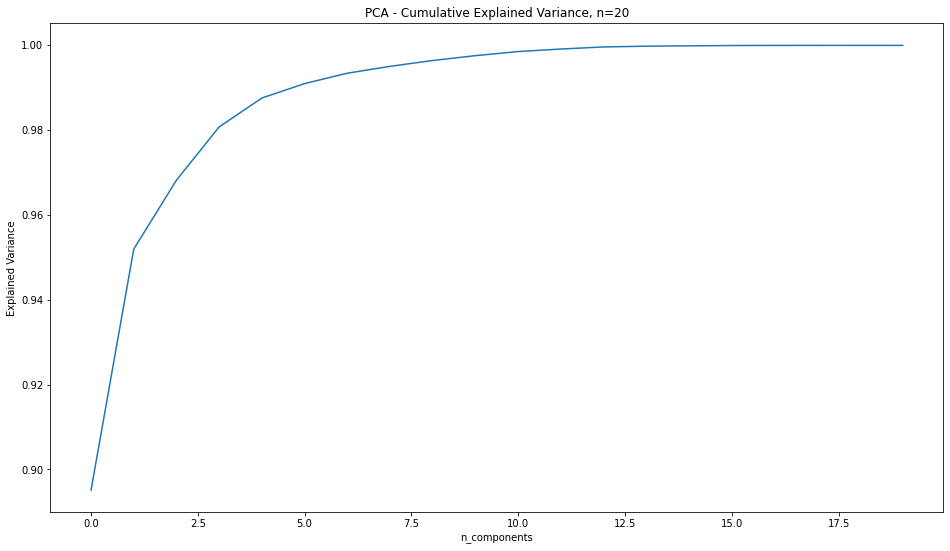

In [8]:
# PCA implemented in model, n_components=8
plt.figure(figsize=(16, 9))
plt.title('PCA - Cumulative Explained Variance, n=8')
plt.xlabel('n_components')
plt.ylabel('Explained Variance')
plt.plot(np.cumsum(pca.explained_variance_ratio_));

# PCA test for variance cutoff, n_components=35
plt.figure(figsize=(16, 9))
plt.title('PCA - Cumulative Explained Variance, n=20')
plt.xlabel('n_components')
plt.ylabel('Explained Variance')
plt.plot(np.cumsum(pca_test.explained_variance_ratio_));

## NN / Modeling

In [9]:
# Referred to an architecture similar to attached research paper
# https://arxiv.org/pdf/1807.07282.pdf

model = Sequential()

model.add(Dense(7, input_dim=Z_train.shape[1], activation='relu', bias_regularizer=l2()))
model.add(Dropout(0.5))
model.add(Dense(15, activation='relu', bias_regularizer=l2()))
model.add(Dropout(0.5))
model.add(Dense(11, activation='relu', bias_regularizer=l2()))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid', bias_regularizer=l2()))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [11]:
# Implementing early stopping
early_stop = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    min_delta=1, 
    patience=5, 
    verbose=0)

In [12]:
history = model.fit(
    Z_train,
    y_train_sm,
    validation_data=(Z_test, y_test),
    epochs=100,
    batch_size=8000,
    callbacks=[early_stop],
    verbose=0
)

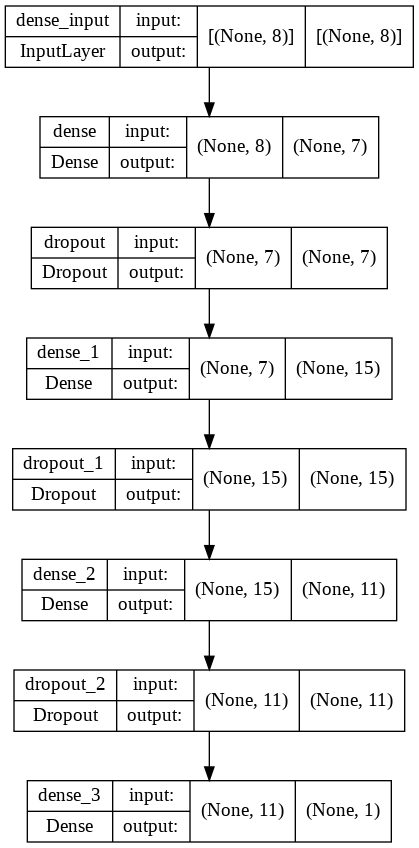

In [13]:
# Model visualization
plot_model(model, show_shapes=True, show_layer_names=True)

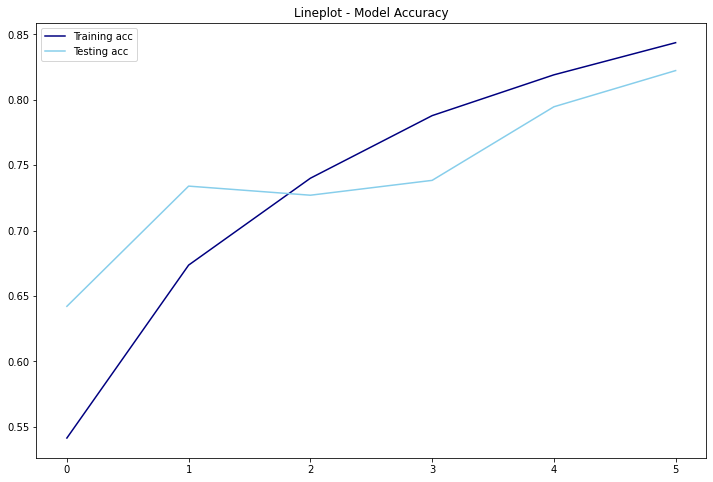

In [14]:
train_acc = history.history['acc']
test_acc = history.history['val_acc']

plt.figure(figsize=(12, 8))
plt.title('Lineplot - Model Accuracy')
plt.plot(train_acc, label='Training acc', color='navy')
plt.plot(test_acc, label='Testing acc', color='skyblue')
plt.legend();

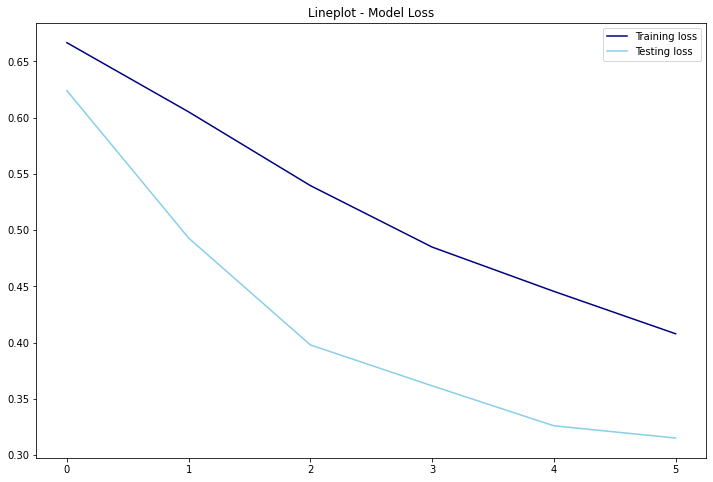

In [15]:
train_loss = history.history['loss']
test_loss = history.history['val_loss']

plt.figure(figsize=(12, 8))
plt.title('Lineplot - Model Loss')
plt.plot(train_loss, label='Training loss', color='navy')
plt.plot(test_loss, label='Testing loss', color='skyblue')
plt.legend();

In [16]:
y_preds = (model.predict(Z_test) > 0.5).astype(int)

In [17]:
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

           0       1.00      0.81      0.90    104230
           1       0.26      1.00      0.41      7016

    accuracy                           0.82    111246
   macro avg       0.63      0.90      0.65    111246
weighted avg       0.95      0.82      0.86    111246



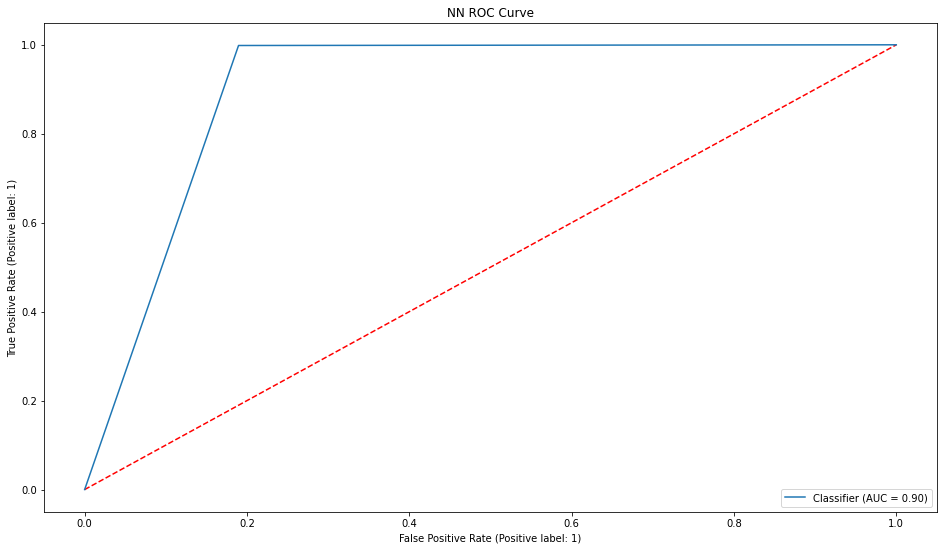

In [18]:
_, ax = plt.subplots(figsize=(16, 9))
ax.title.set_text('NN ROC Curve')
ax.plot(ax.get_xlim(), ax.get_ylim(), ls="--", c="red")
RocCurveDisplay.from_predictions(y_test, y_preds, ax=ax);